```{contents}
```

# Handling Imabalance dataset

## 1. Setup imbalanced data

```python
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score

X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.9, 0.1], n_informative=3,
                           n_samples=1000, random_state=42)
```

---

## 2. Random Undersampling

```python
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

undersample = RandomUnderSampler(random_state=42)
clf = LogisticRegression(solver="liblinear")

pipe = Pipeline([("undersample", undersample), ("clf", clf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv,
                         scoring=make_scorer(f1_score))
print("Random Undersampling F1:", scores.mean())
```

---

## 3. Random Oversampling

```python
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=42)
pipe = Pipeline([("oversample", oversample), ("clf", clf)])

scores = cross_val_score(pipe, X, y, cv=cv,
                         scoring=make_scorer(f1_score))
print("Random Oversampling F1:", scores.mean())
```

---

## 4. SMOTE

```python
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
pipe = Pipeline([("smote", smote), ("clf", clf)])

scores = cross_val_score(pipe, X, y, cv=cv,
                         scoring=make_scorer(f1_score))
print("SMOTE F1:", scores.mean())
```

---

## 5. Hybrid (SMOTE + Tomek Links)

```python
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
pipe = Pipeline([("smotetomek", smote_tomek), ("clf", clf)])

scores = cross_val_score(pipe, X, y, cv=cv,
                         scoring=make_scorer(f1_score))
print("SMOTE+Tomek F1:", scores.mean())
```

---

## 6. Notes

* **StratifiedKFold** preserves class proportions in each fold.
* Use **F1, ROC-AUC, PR-AUC** instead of accuracy.
* Try multiple methods, compare scores, and choose the one that balances precision/recall best.



                     F1   ROC-AUC    PR-AUC
Undersampling  0.875114  0.973184  0.942075
Oversampling   0.888927  0.976004  0.958795
SMOTE          0.896188  0.977760  0.961895
SMOTE+Tomek    0.891758  0.977760  0.961895


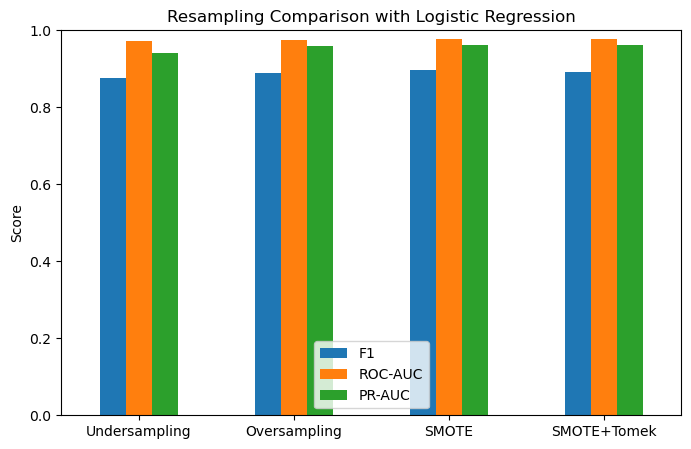

: 

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, average_precision_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 1. Create imbalanced dataset
X, y = make_classification(n_classes=2, class_sep=2,
                           weights=[0.9, 0.1], n_informative=3,
                           n_samples=1000, random_state=42)

# 2. Base classifier
clf = LogisticRegression(solver="liblinear")

# 3. Resampling strategies
strategies = {
    "Undersampling": RandomUnderSampler(random_state=42),
    "Oversampling": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTE+Tomek": SMOTETomek(random_state=42)
}

# 4. Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Scoring metrics
scoring = {
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score, needs_threshold=True),
    "pr_auc": make_scorer(average_precision_score, needs_proba=True)
}

results = {}

# 6. Run experiments
for name, sampler in strategies.items():
    pipe = Pipeline([("resample", sampler), ("clf", clf)])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    results[name] = {
        "F1": np.mean(scores["test_f1"]),
        "ROC-AUC": np.mean(scores["test_roc_auc"]),
        "PR-AUC": np.mean(scores["test_pr_auc"])
    }

# 7. Display results
import pandas as pd
df = pd.DataFrame(results).T
print(df)

# 8. Plot comparison
df.plot(kind="bar", figsize=(8,5))
plt.ylabel("Score")
plt.title("Resampling Comparison with Logistic Regression")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()
